### 0.0 Notes

0. they have analysis for teh results
1. northpointe algorithm is biased towards black people
2. the used a set of 137 questions and "race" is not on of them
3. It produces a "risk score",, which is the likelihod of recommiting a future crime.
4. The score provies an unreliable forvcasting, only 20% of the people predictied to be recomminting actually did it
5. Tests isolating the effects of race, gender and age from criminal history and recedivism were done, but the algorithm still shows that black people are 77% more likely to be pegged as higherrisk of commiting a future crime and 45% more to ommit a future crime of any kind.

I have 2 main questions right now 
  1. How could an algorithm be unfair
  2. even after "5." it still shows the output is biased towards black 
     people, could it be that the questions are designed s.t the are r      racially biased and with the  goal to indict more black people 

### TODO:
0. Some descriptive stats.
1. histogram of black people that are predicted to recommit
2. histogram of white people that are predicted to reccomit
3. percentage of b;acl people that really recommited
4. percentage of white people that really recommited


### Imports

In [28]:
import urllib
import urllib.request
import os,sys
import numpy as np
import pandas as pd
from functools import reduce
pd.set_option('display.max_columns',None)
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.metrics as performance

# from sklearn import feature_extraction
# from sklearn import preprocessing
from random import seed, shuffle
#from __future__ import division
#from collections import defaultdict
#import utils as ut


In [2]:

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
fig=plt.figure(figsize=(10,6))
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


### Downlaod data file

In [3]:

SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)  

Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..


### load and clean data

In [4]:
dataset = pd.read_csv(COMPAS_INPUT_FILE)

print(dataset.shape)

dataset = dataset.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals

dataset = dataset[ (dataset.days_b_screening_arrest <= 30) &
(dataset.days_b_screening_arrest >= -30) &
(dataset.is_recid != -1) & (dataset.c_charge_degree != 'O') & (dataset.score_text != 'N/A') ]

dataset.reset_index(inplace=True, drop=True) # renumber the rows from 0 again

(7214, 53)


In [5]:
dataset.head(10)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,0,1,0,0,0,0.0,2013-11-30 04:50:18,2013-12-01 12:28:56,13022355MM10A,2013-11-30,NaN,0.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-11-30,Risk of Violence,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
4,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,0,6,0,0,14,-1.0,2014-02-18 05:08:24,2014-02-24 12:18:30,14002304CF10A,2014-02-18,NaN,1.0,F,Possession Burglary Tools,1,14004485CF10A,(F2),0.0,2014-03-31,Poss of Firearm by Convic Felo,2014-03-31,2014-04-18,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,6,Medium,2014-02-19,Risk of Violence,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
5,9,steven stewart,steven,stewart,2013-08-30,Male,1973-02-25,43,25 - 45,Other,0,4,0,0,3,-1.0,2013-08-29 08:55:23,2013-08-30 08:42:13,13012216CF10A,NaN,2013-08-29,1.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-08-30,Risk of Violence,3,Low,2013-08-30,2014-05-22,2014-06-03,3,0,265,0,0
6,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,0,1,0,0,0,-1.0,2014-03-15 05:35:34,2014-03-18 04:28:46,14004524MM10A,2014-03-15,NaN,1.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-03-16,Risk of Violence,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
7,14,benjamin franc,benjamin,franc,2013-11-26,Male,1988-06-01,27,25 - 45,Caucasian,0,4,0,0,0,-1.0,2013-11-25 06:31:06,2013-11-26 08:26:57,13016402CF10A,2013-11-25,NaN,1.0,F,"Poss 3,4 MDMA (Ecstasy)",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-11-26,Risk of Violence,4,Low,2013-11-26,2013-11-25,2013-11-26,0,0,857,0,0
8,15,ellyaher lanza,ellyaher,lanza,2013-10-03,Male,1992-08-18,23,Less than 25,African-American,0,6,0,0,3,0.0,2013-10-03 04:07:35,2013-10-07 08:17:30,13018837MM10A,2013-10-03,NaN,0.0,M,Battery,1,14010414TC40A,(M2),NaN,2014-02-08,Driving License Suspended,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,6,Medium,2013-10-03,Risk 

In [6]:
for col in dataset.columns:
    print(col)

id
name
first
last
compas_screening_date
sex
dob
age
age_cat
race
juv_fel_count
decile_score
juv_misd_count
juv_other_count
priors_count
days_b_screening_arrest
c_jail_in
c_jail_out
c_case_number
c_offense_date
c_arrest_date
c_days_from_compas
c_charge_degree
c_charge_desc
is_recid
r_case_number
r_charge_degree
r_days_from_arrest
r_offense_date
r_charge_desc
r_jail_in
r_jail_out
violent_recid
is_violent_recid
vr_case_number
vr_charge_degree
vr_offense_date
vr_charge_desc
type_of_assessment
decile_score.1
score_text
screening_date
v_type_of_assessment
v_decile_score
v_score_text
v_screening_date
in_custody
out_custody
priors_count.1
start
end
event
two_year_recid


In [7]:
# race,  priors_count, is_recid, is_violent_recid, 
# decile_score, score_text, v_decile_score, v_score_text, 

#ground truth: two_year_recid
#compas algorithm output: decile_score, v_decile_score




## Basic analysis of demographics

- What are the different races present in the dataset? 

- What is the number of people by age category?

- What is the number of people by race?

- What is the number of people by COMPAS score (decile_score)?

- What is the number of people by COMPAS risk category (score_text)?

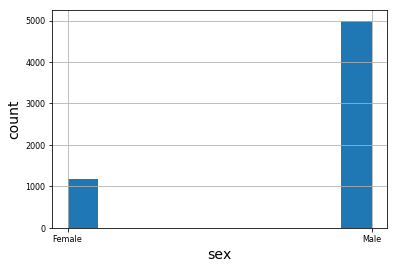

In [8]:
def get_basic_stats(column_name,check_values=None,
                    check_NaN=False,group_count=True,plot_hist = False):
    '''
    basic stats on a given column of the dataset
    @param column_name: column name to compute stats on
    '''
    
    result = {}
    
    if column_name not in dataset.columns:
        raise ValueError("column_name must be set to a value from the the available values")
        
    #values in the column
    column_values = np.unique(dataset[column_name].values)
    
    if check_values:
        print('-',column_name,"in dataset:")
        [print(value) for value in column_values]
#         result.append()

    if check_NaN:
        print("-NaN  presenti n the column?",dataset[column_name].isnull().any())
    
    if group_count:
        #values_count = dataset.groupby(column_name).count()
        #values_count.append([{value:(dataset[column_name] == value).sum()} for value in column_values ])
        
        values_count = dataset[column_name].value_counts()   
#         print('-values count:')
#         pprint(values_count)
        result.update(values_count=values_count)
        
    #histogram of values
    if plot_hist:
        ax = dataset[column_name].hist()
        ax.set_xlabel(column_name)
        ax.set_ylabel('count')
    
    return result
    
        
result = get_basic_stats("sex",plot_hist=True)
# result = get_basic_stats("age")

In [9]:
result = get_basic_stats("race")
print(result['values_count'])

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64


In [10]:
get_basic_stats('decile_score')

{'values_count': 1     1286
 2      822
 4      666
 3      647
 5      582
 6      529
 7      496
 9      420
 8      420
 10     304
 Name: decile_score, dtype: int64}

In [11]:
get_basic_stats('score_text')

{'values_count': Low       3421
 Medium    1607
 High      1144
 Name: score_text, dtype: int64}

In [12]:
# number of african-american with score_text : high
result = get_basic_stats('score_text')
african_american_count_high = dataset[(dataset['race'] == 'African-American') & (dataset['score_text'] == 'High')].count()['id']
print("african america with compass score high: ",african_american_count_high)
print('percentage of african americans with high score {:.2f}%'.format(african_american_count_high /result['values_count']['High']*100))
print('\n')
# number of african-american with score_text : medium
african_american_count_medium = dataset[(dataset['race'] == 'African-American') & (dataset['score_text'] == 'Medium')].count()['id']
print("african america with compass score medium: ",african_american_count_medium)
print('percentage of african americans with medium score {:.2f}%'.format(african_american_count_medium /result['values_count']['Medium']*100))
print('\n')

# number of african-american with score_text : low
african_american_count_low = dataset[(dataset['race'] == 'African-American') & (dataset['score_text'] == 'Low')].count()['id']
print("african america with compass score low: ",african_american_count_medium)
print('percentage of african americans with low score {:.2f}%'.format(african_american_count_low /result['values_count']['Low']*100))
print('\n')


african america with compass score high:  845
percentage of african americans with high score 73.86%


african america with compass score medium:  984
percentage of african americans with medium score 61.23%


african america with compass score low:  984
percentage of african americans with low score 39.35%




### decile score vs race


In [13]:
def scores_stats(category, value):
    '''
    @param category: vategory to perform stats on
    @param value: entry in the specefied category
    '''
    scores = dataset[dataset[category] == value]
    scores = scores[['decile_score','score_text']]
    scores['decile_score'].hist()
    print('mean decile score: %.2f'%scores['decile_score'].mean())


mean decile score: 5.28


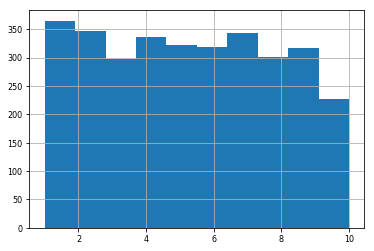

In [14]:
#distribution and mean of decile score for african americans

scores_stats('race','African-American')

mean decile score: 3.64


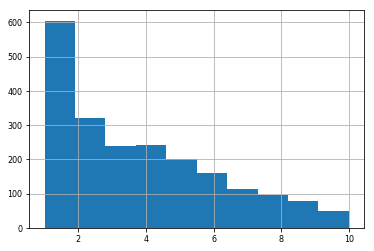

In [15]:
#decile score vs race
# distribution of decile score for Caucasian

scores_stats('race','Caucasian')

### decile score vs gender
#### TODO: add number of males and femals 

mean decile score: 4.50


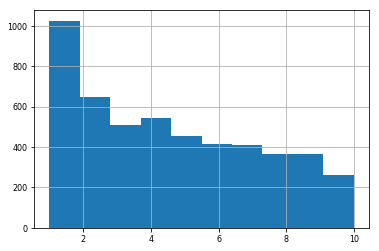

In [16]:
# distribution of decile score for males

scores_stats('sex','Male')

mean decile score: 4.06


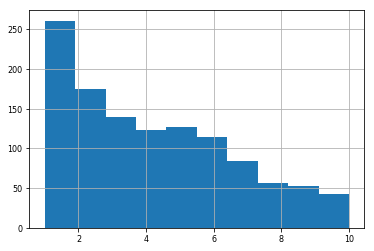

In [17]:
# distribution of decile score for Females 

scores_stats('sex','Female')

1. Compute basic performance metrics of the COMPAS classifier for different races/genders.

2. Do you see a difference? Are there other analyses that you could do to investigate how different races/genders are treated by the COMPAS classifier?

The two_year_recid field records whether or not each person was re-arrested for a violent offense within two years, which is what COMPAS is trying to predict.


1. How many people were re-arrested?


In [18]:
#people whom got re-arrested in two years span
dataset['two_year_recid'].sum()

2809

2. Compute the recidivism (i.e., people that got re-arrested) rates by race and gender


In [19]:
# recedivism bs race

dataset[(dataset['race'] == 'Caucasian') & (dataset['two_year_recid']==1)]['two_year_recid'].sum()

822

In [20]:
dataset[(dataset['race'] == 'African-American') & (dataset['two_year_recid']==1)]['two_year_recid'].sum()

1661

In [21]:
#recedivism by gender
dataset[(dataset['sex'] == 'Male') & (dataset['two_year_recid']==1)]['two_year_recid'].sum()

2396

In [22]:
dataset[(dataset['sex'] == 'Female') & (dataset['two_year_recid']==1)]['two_year_recid'].sum()

413

In [23]:
#mapping of low medium high to decile score
scores = dataset[['decile_score','score_text']]
low_range = scores[scores['score_text'] == 'Low']['decile_score']
print(low_range.min(),low_range.max())
medium_range = scores[scores['score_text'] == 'Medium']['decile_score']
print(medium_range.min(),medium_range.max())
High_range = scores[scores['score_text'] == 'High']['decile_score']
print(High_range.min(),High_range.max())

1 4
5 7
8 10


In [24]:
# we split scores to new classes, high to 1 and medium/ low to zero
new_scores = dataset.copy()
new_scores['decile_score'].replace(to_replace=range(1,8),value=0,inplace=True)
# new_scores['decile_score'].replace(to_replace=[5,6,7],value=1,inplace=True)
new_scores['decile_score'].replace(to_replace=range(8,11),value=1,inplace=True)


3. What is the accuracy of the COMPAS scores to predict recidivism


In [30]:
performance.accuracy_score(new_scores['two_year_recid'],new_scores['decile_score'],normalize=True)

0.6339922229423202

4. Is the accuracy higher/lower if we look at particular races/genders?


### accuracy for african american

In [42]:
new_scores_african_american = new_scores[new_scores['race'] == 'African-American']
performance.accuracy_score(new_scores_african_american['two_year_recid'],new_scores_african_american['decile_score'],normalize=True)

performance.confusion_matrix(new_scores_african_american['two_year_recid'],new_scores_african_american['decile_score'])


array([[1303,  211],
       [1027,  634]])

### accuracy for Caucasians

In [36]:
new_scores_Caucasian = new_scores[new_scores['race'] == 'Caucasian']
performance.accuracy_score(new_scores_Caucasian['two_year_recid'],new_scores_Caucasian['decile_score'],normalize=True)

0.6571564431764146

### Accuracy for females

In [37]:
new_scores_female = new_scores[new_scores['sex'] == 'Female']
performance.accuracy_score(new_scores_female['two_year_recid'],new_scores_female['decile_score'],normalize=True)

0.6868085106382978

### accuracy for males


In [38]:
new_scores_male = new_scores[new_scores['sex'] == 'Male']
performance.accuracy_score(new_scores_male['two_year_recid'],new_scores_male['decile_score'],normalize=True)

0.6215729437662597

5. What about false positives and false negatives?
